In [1]:
import os
import tqdm as tqdm
import numpy as np
import copy

# 处理服务器中evo的可视化问题
import evo
from evo.tools.settings import SETTINGS
SETTINGS['plot_backend'] = 'Agg'

from evo.tools import file_interface, plot
from evo.core.geometry import GeometryException
import evo.main_ape as main_ape
from evo.core import sync, metrics
from evo.core.trajectory import PoseTrajectory3D

import matplotlib.pyplot as plt #绘图

print("Successfully import ultils")

Successfully import ultils


In [2]:
def make_evo_traj(poses_N_x_7, tss_us):
    assert poses_N_x_7.shape[1] == 7
    assert poses_N_x_7.shape[0] > 10
    assert tss_us.shape[0] == poses_N_x_7.shape[0]

    traj_evo = PoseTrajectory3D(
        positions_xyz=poses_N_x_7[:,:3],
        orientations_quat_wxyz=poses_N_x_7[:,3:],
        timestamps=tss_us/1e6)#转换为秒
    return traj_evo

def load_gt_us(path, skiprows=0):
    traj_ref = np.loadtxt(path, delimiter=" ", skiprows=skiprows)
    tss_gt_us = traj_ref[:, 0].copy() 
    assert np.all(tss_gt_us == sorted(tss_gt_us))
    assert traj_ref.shape[0] > 0
    assert traj_ref.shape[1] == 8

    return tss_gt_us, traj_ref[:, 1:]

def plot_trajectory_inxyplane(pred_traj, gt_traj, align=True, _n_to_align=-1,correct_scale=True, max_diff_sec=1.0,title="", filename=""):
    #将两个轨迹对齐(时间维度上的)
    gt_traj, pred_traj = sync.associate_trajectories(gt_traj, pred_traj, max_diff=max_diff_sec)

    # 对齐轨迹(空间维度上的)
    if align:
        try:
            pred_traj.align(gt_traj, correct_scale=correct_scale,n=_n_to_align)
        except GeometryException as e:
            print("Plotting error:", e)

    plot_collection = plot.PlotCollection("PlotCol")

    fig = plt.figure(figsize=(8, 8))
    plot_mode = plot.PlotMode.xy
    ax = plot.prepare_axis(fig, plot_mode)
    ax.set_title(title)
    if gt_traj is not None:
        plot.traj(ax, plot_mode, gt_traj, '--', 'gray', "Ground Truth")
    plot.traj(ax, plot_mode, pred_traj, '-', 'blue', "Predicted")
    
    plot_collection.add_figure("traj (error)", fig)

    plt.show()

print("Successfully define several functions")

Successfully define several functions


Evaluation for MVSEC dataset


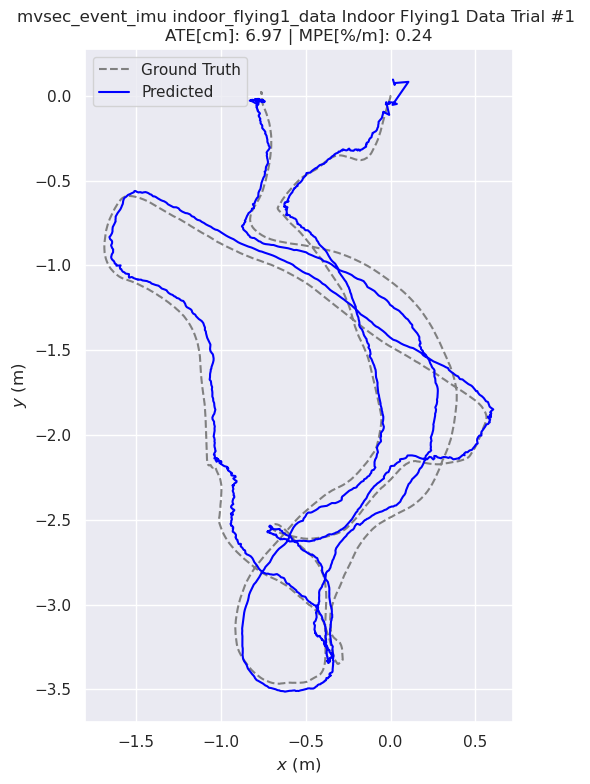

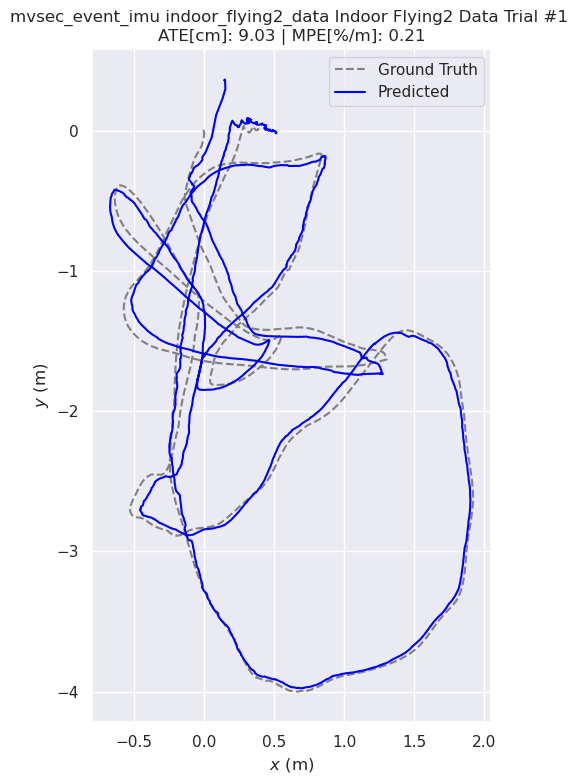

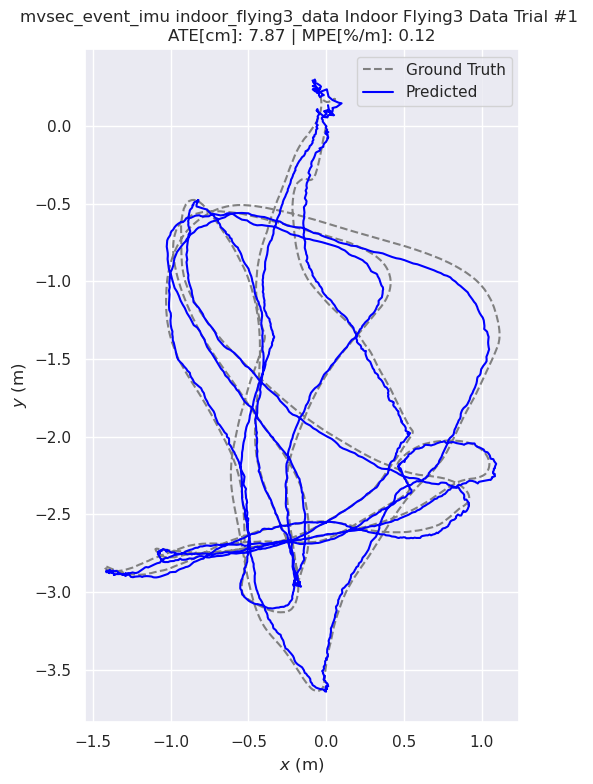

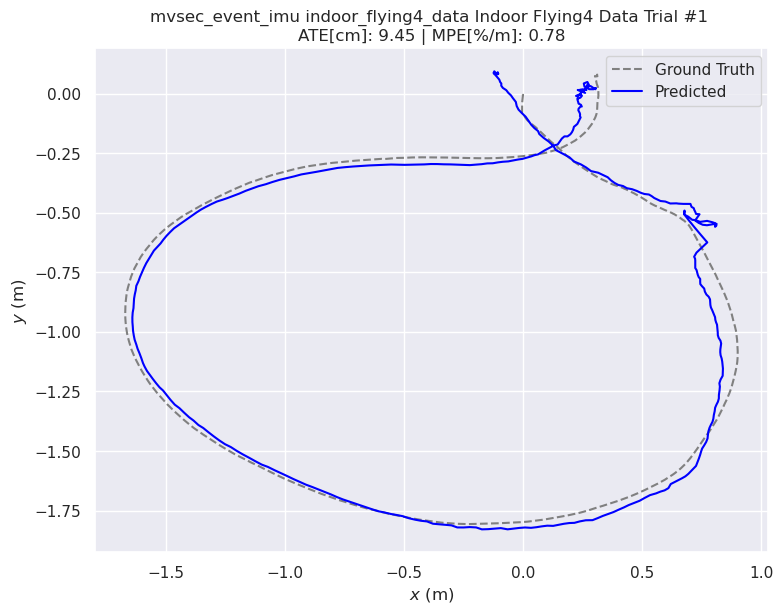

In [6]:
print("Evaluation for MVSEC dataset")
indir="/media/lfl-data2/MVSEC/"

target_dirs = {
                "indoor_flying1_data",
                "indoor_flying2_data",
                "indoor_flying3_data",
                "indoor_flying4_data", 
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_gt_stamped_us.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "indoor_flying1_data":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/MVSEC/2024-10-11_indoor_flying1_data/Indoor_Flying1_Data_trial_1_step_DEVOimu/Indoor_Flying1_Data_Trial01.txt")
            elif sequence_name == "indoor_flying2_data":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/MVSEC/2024-10-23_indoor_flying2_data/Indoor_Flying2_Data_trial_1_step_DEVOimu/Indoor_Flying2_Data_Trial01.txt")
            elif sequence_name == "indoor_flying3_data":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/MVSEC/2024-10-23_indoor_flying3_data/Indoor_Flying3_Data_trial_1_step_DEVOimu/Indoor_Flying3_Data_Trial01.txt")
            elif sequence_name == "indoor_flying4_data":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/MVSEC/2024-10-11_indoor_flying4_data/Indoor_Flying4_Data_trial_1_step_DEVOimu/Indoor_Flying4_Data_Trial01.txt")


            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=-1;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            dataset_name="mvsec_event_imu"
            expname=sequence_name
            scene_name = '_'.join(sequence_name.split('/')[1:]).title() if "/P0" in sequence_name else sequence_name.title()
            trial=1
            figure_title=f"{dataset_name} {expname} {scene_name.replace('_', ' ')} Trial #{trial} {res_str}"

            # 在 Jupyter 中确保绘图可以显示
            %matplotlib inline 
            
            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoDEIO = make_evo_traj(traj_deio, tss_deio_us)
            plot_trajectory_inxyplane(pred_traj=evoDEIO, gt_traj=evoGT, _n_to_align=-1, max_diff_sec=0.01, title=figure_title)
            
    # 使用break限制os.walk只遍历indir的第一层
    break



In [5]:
print("Evaluation for DAVIS240c dataset")
indir="/media/lfl-data2/davis240c/"

target_dirs = {
                "boxes_6dof",
                "boxes_translation",
                "dynamic_6dof",
                "dynamic_translation",
                "hdr_boxes",
                "hdr_poster",
                "poster_6dof",
                "poster_translation",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_gt_stamped_ns_left.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "boxes_6dof":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_boxes_6dof/Boxes_6Dof_trial_1_step_DEVOimu/Boxes_6Dof_Trial01.txt")
            elif sequence_name == "boxes_translation":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_boxes_translation/Boxes_Translation_trial_1_step_DEVOimu/Boxes_Translation_Trial01.txt")
            elif sequence_name == "dynamic_6dof":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_dynamic_6dof/Dynamic_6Dof_trial_1_step_DEVOimu/Dynamic_6Dof_Trial01.txt")
            elif sequence_name == "dynamic_translation":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_dynamic_translation/Dynamic_Translation_trial_1_step_DEVOimu/Dynamic_Translation_Trial01.txt")
            elif sequence_name == "hdr_boxes":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_hdr_boxes/Hdr_Boxes_trial_1_step_DEVOimu/Hdr_Boxes_Trial01.txt")
            elif sequence_name == "hdr_poster":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_hdr_poster/Hdr_Poster_trial_1_step_DEVOimu/Hdr_Poster_Trial01.txt")   
            elif sequence_name == "poster_6dof":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_poster_6dof/Poster_6Dof_trial_1_step_DEVOimu/Poster_6Dof_Trial01.txt")
            elif sequence_name == "poster_translation":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DAVIS240C/2024-10-06_poster_translation/Poster_Translation_trial_1_step_DEVOimu/Poster_Translation_Trial01.txt")         

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=1000;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for DAVIS240c dataset


boxes_6dof: 
ATE[cm]: 4.47 | MPE[%/m]: 0.05
boxes_translation: 
ATE[cm]: 6.69 | MPE[%/m]: 0.07
dynamic_6dof: 
ATE[cm]: 1.93 | MPE[%/m]: 0.04
dynamic_translation: 
ATE[cm]: 2.00 | MPE[%/m]: 0.06
hdr_boxes: 
ATE[cm]: 5.81 | MPE[%/m]: 0.09
hdr_poster: 
ATE[cm]: 3.87 | MPE[%/m]: 0.06
poster_6dof: 
ATE[cm]: 6.19 | MPE[%/m]: 0.08
poster_translation: 
ATE[cm]: 2.17 | MPE[%/m]: 0.04


In [9]:
print("Evaluation for MONO-HKU dataset")
indir="/media/lfl-data2/Mono_HKU/"

target_dirs = {
                "vicon_dark1",
                "vicon_dark2",
                "vicon_darktolight1",
                "vicon_darktolight2",
                "vicon_hdr1",
                "vicon_hdr2",
                "vicon_hdr3",
                "vicon_hdr4",
                "vicon_lighttodark1",
                "vicon_lighttodark2",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_gt_stamped_us.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "vicon_dark1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_dark1/Vicon_Dark1_trial_1_step_DEVOimu/Vicon_Dark1_Trial01.txt")
            elif sequence_name == "vicon_dark2":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_dark2/Vicon_Dark2_trial_1_step_DEVOimu/Vicon_Dark2_Trial01.txt")
            elif sequence_name == "vicon_darktolight1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_darktolight1/Vicon_Darktolight1_trial_1_step_DEVOimu/Vicon_Darktolight1_Trial01.txt")
            elif sequence_name == "vicon_darktolight2":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_darktolight2/Vicon_Darktolight2_trial_1_step_DEVOimu/Vicon_Darktolight2_Trial01.txt")
            elif sequence_name == "vicon_hdr1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_hdr1/Vicon_Hdr1_trial_1_step_DEVOimu/Vicon_Hdr1_Trial01.txt")
            elif sequence_name == "vicon_hdr2":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_hdr2/Vicon_Hdr2_trial_1_step_DEVOimu/Vicon_Hdr2_Trial01.txt")
            elif sequence_name == "vicon_hdr3":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_hdr3/Vicon_Hdr3_trial_1_step_DEVOimu/Vicon_Hdr3_Trial01.txt")
            elif sequence_name == "vicon_hdr4":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_hdr4/Vicon_Hdr4_trial_1_step_DEVOimu/Vicon_Hdr4_Trial01.txt")
            elif sequence_name == "vicon_lighttodark1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_lighttodark1/Vicon_Lighttodark1_trial_1_step_DEVOimu/Vicon_Lighttodark1_Trial01.txt")
            elif sequence_name == "vicon_lighttodark2":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Mono-HKU/2024-10-09_vicon_lighttodark2/Vicon_Lighttodark2_trial_1_step_DEVOimu/Vicon_Lighttodark2_Trial01.txt")     

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=251;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for MONO-HKU dataset
vicon_dark1: 
ATE[cm]: 2.90 | MPE[%/m]: 0.05
vicon_dark2: 
ATE[cm]: 5.98 | MPE[%/m]: 0.08
vicon_darktolight1: 
ATE[cm]: 7.30 | MPE[%/m]: 0.11
vicon_darktolight2: 
ATE[cm]: 5.25 | MPE[%/m]: 0.10
vicon_hdr1: 
ATE[cm]: 9.04 | MPE[%/m]: 0.14
vicon_hdr2: 
ATE[cm]: 6.66 | MPE[%/m]: 0.09
vicon_hdr3: 
ATE[cm]: 5.72 | MPE[%/m]: 0.16
vicon_hdr4: 
ATE[cm]: 5.80 | MPE[%/m]: 0.07
vicon_lighttodark1: 
ATE[cm]: 7.28 | MPE[%/m]: 0.11
vicon_lighttodark2: 
ATE[cm]: 6.09 | MPE[%/m]: 0.13


In [11]:
print("Evaluation for Stereo-HKU dataset")
indir="/media/lfl-data2/Steroe_HKU/"

target_dirs = {
                "HKU_aggressive_translation",
                "HKU_aggressive_rotation",
                "HKU_aggressive_small_flip",
                "hku_aggressive_walk",
                "HKU_HDR_circle",
                "HKU_HDR_slow",
                "hku_hdr_tran_rota",
                "hku_hdr_agg",
                "hku_dark_normal",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_gt_stamped_us.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "HKU_aggressive_translation":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_HKU_aggressive_translation/Hku_Aggressive_Translation_trial_1_step_DEVOimu/Hku_Aggressive_Translation_Trial01.txt")
            elif sequence_name == "HKU_aggressive_rotation":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_HKU_aggressive_rotation/Hku_Aggressive_Rotation_trial_1_step_DEVOimu/Hku_Aggressive_Rotation_Trial01.txt")
            elif sequence_name == "HKU_aggressive_small_flip":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_HKU_aggressive_small_flip/Hku_Aggressive_Small_Flip_trial_1_step_DEVOimu/Hku_Aggressive_Small_Flip_Trial01.txt")
            elif sequence_name == "hku_aggressive_walk":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-10_hku_aggressive_walk/Hku_Aggressive_Walk_trial_1_step_DEVOimu/Hku_Aggressive_Walk_Trial01.txt")
            elif sequence_name == "HKU_HDR_circle":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_HKU_HDR_circle/Hku_Hdr_Circle_trial_1_step_DEVOimu/Hku_Hdr_Circle_Trial01.txt")
            elif sequence_name == "HKU_HDR_slow":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_HKU_HDR_slow/Hku_Hdr_Slow_trial_1_step_DEVOimu/Hku_Hdr_Slow_Trial01.txt")
            elif sequence_name == "hku_hdr_tran_rota":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_hku_hdr_tran_rota/Hku_Hdr_Tran_Rota_trial_1_step_DEVOimu/Hku_Hdr_Tran_Rota_Trial01.txt")
            elif sequence_name == "hku_hdr_agg":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_hku_hdr_agg/Hku_Hdr_Agg_trial_1_step_DEVOimu/Hku_Hdr_Agg_Trial01.txt")
            elif sequence_name == "hku_dark_normal":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/Stereo-HKU/2024-10-09_hku_dark_normal/Hku_Dark_Normal_trial_1_step_DEVOimu/Hku_Dark_Normal_Trial01.txt")

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=-1;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for Stereo-HKU dataset
HKU_aggressive_rotation: 
ATE[cm]: 6.45 | MPE[%/m]: 0.09
HKU_aggressive_small_flip: 
ATE[cm]: 9.86 | MPE[%/m]: 0.20
HKU_aggressive_translation: 
ATE[cm]: 4.37 | MPE[%/m]: 0.06
hku_aggressive_walk: 
ATE[cm]: 45.71 | MPE[%/m]: 0.48
hku_dark_normal: 
ATE[cm]: 10.75 | MPE[%/m]: 0.11
hku_hdr_agg: 
ATE[cm]: 6.68 | MPE[%/m]: 0.06
HKU_HDR_circle: 
ATE[cm]: 8.17 | MPE[%/m]: 0.14
HKU_HDR_slow: 
ATE[cm]: 4.38 | MPE[%/m]: 0.07
hku_hdr_tran_rota: 
ATE[cm]: 6.37 | MPE[%/m]: 0.09


In [12]:
print("Evaluation for VECtor dataset")
indir="/media/lfl-data2/VECtor_h5/"

target_dirs = {
                "corner_slow1",
                "desk_normal1",
                "sofa_fast1",
                "mountain_fast1",
                "corridors_dolly1",
                "corridors_walk1",
                "units_dolly1",
                "units_scooter1",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"poses_evs_left.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "corner_slow1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-13_corner_slow1/Corner_Slow1_trial_1_step_DEVOimu/Corner_Slow1_Trial01.txt")
            elif sequence_name == "desk_normal1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-13_desk_normal1/Desk_Normal1_trial_1_step_DEVOimu/Desk_Normal1_Trial01.txt")
            elif sequence_name == "sofa_fast1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-10_sofa_fast1/Sofa_Fast1_trial_1_step_DEVOimu/Sofa_Fast1_Trial01.txt")
            elif sequence_name == "mountain_fast1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-14_mountain_fast1/Mountain_Fast1_trial_1_step_DEVOimu/Mountain_Fast1_Trial01.txt")
            elif sequence_name == "corridors_dolly1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-12_corridors_dolly1/Corridors_Dolly1_trial_1_step_DEVOimu/Corridors_Dolly1_Trial01.txt")
            elif sequence_name == "corridors_walk1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-12_corridors_walk1/Corridors_Walk1_trial_1_step_DEVOimu/Corridors_Walk1_Trial01.txt")
            elif sequence_name == "units_dolly1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-12_units_dolly1/Units_Dolly1_trial_1_step_DEVOimu/Units_Dolly1_Trial01.txt")
            elif sequence_name == "units_scooter1":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/VECtor/2024-10-12_units_scooter1/Units_Scooter1_trial_1_step_DEVOimu/Units_Scooter1_Trial01.txt")

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=-1;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for VECtor dataset
corner_slow1: 
ATE[cm]: 0.87 | MPE[%/m]: 0.50
corridors_dolly1: 
ATE[cm]: 74.88 | MPE[%/m]: 0.78
corridors_walk1: 
ATE[cm]: 68.50 | MPE[%/m]: 0.74
desk_normal1: 
ATE[cm]: 1.39 | MPE[%/m]: 0.13
mountain_fast1: 
ATE[cm]: 8.87 | MPE[%/m]: 0.24
sofa_fast1: 
ATE[cm]: 16.52 | MPE[%/m]: 0.44
units_dolly1: 
ATE[cm]: 101.19 | MPE[%/m]: 0.35
units_scooter1: 
ATE[cm]: 101.16 | MPE[%/m]: 0.35


In [13]:
print("Evaluation for TUM-VIE dataset")
indir="/media/lfl-data2/TUM-VIE/"

target_dirs = {
                "mocap-1d-trans",
                "mocap-3d-trans",
                "mocap-6dof",
                "mocap-desk",
                "mocap-desk2",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"mocap_data.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "mocap-1d-trans":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/TUM-VIE/2024-10-19_mocap-1d-trans/Mocap-1D-Trans_trial_1_step_DEVOimu_camID_2/Mocap-1D-Trans_Trial01.txt")
            elif sequence_name == "mocap-3d-trans" :
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/TUM-VIE/2024-10-19_mocap-3d-trans/Mocap-3D-Trans_trial_1_step_DEVOimu_camID_2/Mocap-3D-Trans_Trial01.txt")
            elif sequence_name == "mocap-6dof":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/TUM-VIE/2024-10-19_mocap-6dof/Mocap-6Dof_trial_1_step_DEVOimu_camID_2/Mocap-6Dof_Trial01.txt")
            elif sequence_name == "mocap-desk":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/TUM-VIE/2024-10-19_mocap-desk/Mocap-Desk_trial_1_step_DEVOimu_camID_2/Mocap-Desk_Trial01.txt")
            elif sequence_name == "mocap-desk2":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/TUM-VIE/2024-10-19_mocap-desk2/Mocap-Desk2_trial_1_step_DEVOimu_camID_2/Mocap-Desk2_Trial01.txt")            

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=-1;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for TUM-VIE dataset
mocap-1d-trans: 
ATE[cm]: 0.42 | MPE[%/m]: 0.08
mocap-3d-trans: 
ATE[cm]: 1.11 | MPE[%/m]: 0.15
mocap-6dof: 
ATE[cm]: 1.37 | MPE[%/m]: 0.22
mocap-desk: 
ATE[cm]: 1.37 | MPE[%/m]: 0.13
mocap-desk2: 
ATE[cm]: 0.74 | MPE[%/m]: 0.12


In [14]:
print("Evaluation for UZH-FPV dataset")
indir="/media/lfl-data2/UZH-FPV/"

target_dirs = {
                "indoor_forward_3_davis_with_gt",
                "indoor_forward_5_davis_with_gt",
                "indoor_forward_6_davis_with_gt",
                "indoor_forward_7_davis_with_gt",
                "indoor_forward_9_davis_with_gt",
                "indoor_forward_10_davis_with_gt",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_gt_us, traj_gt = load_gt_us(os.path.join(datapath_val, f"raw_stamped_groundtruth_us.txt"))#获取真实轨迹

            # 获取deio估算的轨迹
            if sequence_name == "indoor_forward_3_davis_with_gt":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/UZH-FPV/2024-10-08_indoor_forward_3_davis_with_gt/Indoor_Forward_3_Davis_With_Gt_trial_1_step_DEVOimu/Indoor_Forward_3_Davis_With_Gt_Trial01.txt")
            elif sequence_name == "indoor_forward_5_davis_with_gt":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/UZH-FPV/2024-10-08_indoor_forward_5_davis_with_gt/Indoor_Forward_5_Davis_With_Gt_trial_1_step_DEVOimu/Indoor_Forward_5_Davis_With_Gt_Trial01.txt")
            elif sequence_name == "indoor_forward_6_davis_with_gt":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/UZH-FPV/2024-10-08_indoor_forward_6_davis_with_gt/Indoor_Forward_6_Davis_With_Gt_trial_1_step_DEVOimu/Indoor_Forward_6_Davis_With_Gt_Trial01.txt")
            elif sequence_name == "indoor_forward_7_davis_with_gt":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/UZH-FPV/2024-10-08_indoor_forward_7_davis_with_gt/Indoor_Forward_7_Davis_With_Gt_trial_1_step_DEVOimu/Indoor_Forward_7_Davis_With_Gt_Trial01.txt")
            elif sequence_name == "indoor_forward_9_davis_with_gt":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/UZH-FPV/2024-10-08_indoor_forward_9_davis_with_gt/Indoor_Forward_9_Davis_With_Gt_trial_1_step_DEVOimu/Indoor_Forward_9_Davis_With_Gt_Trial01.txt")
            elif sequence_name == "indoor_forward_10_davis_with_gt":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/UZH-FPV/2024-10-08_indoor_forward_10_davis_with_gt/Indoor_Forward_10_Davis_With_Gt_trial_1_step_DEVOimu/Indoor_Forward_10_Davis_With_Gt_Trial01.txt")         

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=-1;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for UZH-FPV dataset
indoor_forward_10_davis_with_gt: 
ATE[cm]: 84.13 | MPE[%/m]: 0.55
indoor_forward_3_davis_with_gt: 
ATE[cm]: 126.69 | MPE[%/m]: 0.39
indoor_forward_5_davis_with_gt: 
ATE[cm]: 21.51 | MPE[%/m]: 0.36
indoor_forward_6_davis_with_gt: 
ATE[cm]: 76.76 | MPE[%/m]: 0.33
indoor_forward_7_davis_with_gt: 
ATE[cm]: 114.05 | MPE[%/m]: 0.32
indoor_forward_9_davis_with_gt: 
ATE[cm]: 86.47 | MPE[%/m]: 0.59


In [18]:
print("Evaluation for DSEC dataset")
indir="/media/lfl-data2/DSEC/"

target_dirs = {
                "dsec_zurich_city_04_a",
                "dsec_zurich_city_04_b",
                "dsec_zurich_city_04_c",
                "dsec_zurich_city_04_d",
                "dsec_zurich_city_04_e",
                }

for root, dirs, files in os.walk(indir):
    for d in dirs:
        # 构建完整路径 data_path
        datapath_val = os.path.join(root, d)

        # 检查是否为目标文件夹之一
        if os.path.basename(datapath_val) in target_dirs:
            sequence_name = os.path.basename(datapath_val)

            # 获取轨迹
            tss_traj_s, traj_gt = load_gt_us(os.path.join(datapath_val, "trajectory","stamped_groundtruth2.txt"))#获取真实轨迹
            tss_gt_us=tss_traj_s * 1e6#转换为微秒

            # 获取deio估算的轨迹
            if sequence_name == "dsec_zurich_city_04_a":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DSEC/2024-10-17_dsec_zurich_city_04_a/Dsec_Zurich_City_04_A_trial_1_step_DEVOimu/Dsec_Zurich_City_04_A_Trial01.txt")
            elif sequence_name == "dsec_zurich_city_04_b":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DSEC/2024-10-16_dsec_zurich_city_04_b/Dsec_Zurich_City_04_B_trial_1_step_DEVOimu/Dsec_Zurich_City_04_B_Trial01.txt")
            elif sequence_name == "dsec_zurich_city_04_c":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DSEC/2024-10-16_dsec_zurich_city_04_c/Dsec_Zurich_City_04_C_trial_1_step_DEVOimu/Dsec_Zurich_City_04_C_Trial01.txt")
            elif sequence_name == "dsec_zurich_city_04_d":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DSEC/2024-10-16_dsec_zurich_city_04_d/Dsec_Zurich_City_04_D_trial_1_step_DEVOimu/Dsec_Zurich_City_04_D_Trial01.txt")
            elif sequence_name == "dsec_zurich_city_04_e":
                tss_deio_us, traj_deio = load_gt_us("/home/gwp/Estimated_Trajectories/DSEC/2024-10-16_dsec_zurich_city_04_e/Dsec_Zurich_City_04_E_trial_1_step_DEVOimu/Dsec_Zurich_City_04_E_Trial01.txt")      

            evoGT = make_evo_traj(traj_gt, tss_gt_us)
            evoEst = make_evo_traj(traj_deio, tss_deio_us)
            gtlentraj = evoGT.get_infos()["path length (m)"]#获取轨迹长度
            evoGT, evoEst = sync.associate_trajectories(evoGT, evoEst, max_diff=1)
            _n_to_align=-1;
            ape_trans = main_ape.ape(copy.deepcopy(evoGT), copy.deepcopy(evoEst), pose_relation=metrics.PoseRelation.translation_part, align=True,n_to_align=_n_to_align, correct_scale=True)

            # print(f"\033[31m EVO结果：{ape_trans}\033[0m");
            MPE = ape_trans.stats["mean"] / gtlentraj * 100
            # print(f"MPE is {MPE:.02f}") #注意只保留两位小数
            evoATE = ape_trans.stats["rmse"]*100

            res_str = f"\nATE[cm]: {evoATE:.02f} | MPE[%/m]: {MPE:.02f}"
            
            print(f"{sequence_name}: {res_str}")
            
    # 使用break限制os.walk只遍历indir的第一层
    break



Evaluation for DSEC dataset
dsec_zurich_city_04_a: 
ATE[cm]: 82.46 | MPE[%/m]: 0.30
dsec_zurich_city_04_b: 
ATE[cm]: 35.36 | MPE[%/m]: 0.41
dsec_zurich_city_04_c: 
ATE[cm]: 413.83 | MPE[%/m]: 0.66
dsec_zurich_city_04_d: 
ATE[cm]: 207.63 | MPE[%/m]: 0.36
dsec_zurich_city_04_e: 
ATE[cm]: 86.07 | MPE[%/m]: 0.37
